# **1.Import Library**

In [2]:
import os
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import shutil 
import random
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout


# **2. Load Dataset Dan Melihat Struktur Dataset**

In [3]:
dataset_dir ="dataset_sampah"
classes = os.listdir(dataset_dir)

print("Jumlah kelas:", len(classes))
print("Daftar kelas:", classes)

for cls in classes:
    cls_path = os.path.join(dataset_dir, cls)
    n_image = len(os.listdir(cls_path))
    print(f"Jumlah gambar kelas {cls}: {n_image}")


Jumlah kelas: 6
Daftar kelas: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Jumlah gambar kelas cardboard: 403
Jumlah gambar kelas glass: 501
Jumlah gambar kelas metal: 410
Jumlah gambar kelas paper: 594
Jumlah gambar kelas plastic: 482
Jumlah gambar kelas trash: 137


# **3. Split Dataset**

In [4]:
def split_dataset(src_dir, dest_dir, train_ratio=0.7, val_ratio=0.15):
    classes = os.listdir(src_dir)
    for cls in classes:
        src_path = os.path.join(src_dir, cls)
        images = os.listdir(src_path)
        random.shuffle(images)

        total = len(images)
        train_end = int(train_ratio * total)
        val_end = int((train_ratio + val_ratio) * total)

        splits={
            "train": images[:train_end],
            "val": images[train_end:val_end],
            "test": images[val_end:]
        }

        for split_name, file_list in splits.items():
            dest_path = os.path.join(dest_dir, split_name, cls)
            os.makedirs(dest_path, exist_ok=True)
            for img_file in file_list:
                src_file = os.path.join(src_path, img_file)
                dst_file = os.path.join(dest_path, img_file)
                shutil.copy2(src_file, dst_file)

    print("Dataset berhasil dibagi!")

split_dataset("dataset_sampah", "dataset_split")

Dataset berhasil dibagi!


# **4. Data Augmentasi**

In [5]:
img_height = 150
img_width = 150
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.2,
    validation_split=0.2
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "dataset_split/train",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    "dataset_split/val",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    "dataset_split/test",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  
)


Found 2494 images belonging to 6 classes.
Found 1195 images belonging to 6 classes.
Found 1235 images belonging to 6 classes.


# **5. Membuat Model CNN**

In [ ]:
# Bangun ulang model dulu dengan arsitektur yang sama
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])


# **6.Compile dan Training Model CNN**

In [13]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_model.weights.h5", save_best_only=True, save_weights_only=True)
]

history = model.fit(
    train_generator,
    epochs=90,
    validation_data=val_generator,
    callbacks=callbacks
)

final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f" Akurasi Akhir (Train): {final_train_acc:.2%}")
print(f" Akurasi Akhir (Val): {final_val_acc:.2%}")

loss, accuracy = model.evaluate(val_generator)
print(f" Akurasi Model Terbaik dari File: {accuracy:.2%}")



Epoch 1/90
78/78 ━━━━━━━━━━━━━━━━━━━━ 43s 535ms/step - accuracy: 0.6297 - loss: 0.9955 - val_accuracy: 0.7356 - val_loss: 0.7239
Epoch 2/90
78/78 ━━━━━━━━━━━━━━━━━━━━ 34s 439ms/step - accuracy: 0.6715 - loss: 0.8773 - val_accuracy: 0.7138 - val_loss: 0.7725
Epoch 3/90
78/78 ━━━━━━━━━━━━━━━━━━━━ 33s 425ms/step - accuracy: 0.7193 - loss: 0.7941 - val_accuracy: 0.6117 - val_loss: 1.1717
Epoch 4/90
78/78 ━━━━━━━━━━━━━━━━━━━━ 33s 428ms/step - accuracy: 0.7029 - loss: 0.8225 - val_accuracy: 0.7858 - val_loss: 0.6038
Epoch 5/90
78/78 ━━━━━━━━━━━━━━━━━━━━ 33s 429ms/step - accuracy: 0.7438 - loss: 0.7084 - val_accuracy: 0.7891 - val_loss: 0.6036
Epoch 6/90
78/78 ━━━━━━━━━━━━━━━━━━━━ 33s 428ms/step - accuracy: 0.7238 - loss: 0.7684 - val_accuracy: 0.8042 - val_loss: 0.5583
Epoch 7/90
78/78 ━━━━━━━━━━━━━━━━━━━━ 34s 432ms/step - accuracy: 0.7430 - loss: 0.7064 - val_accuracy: 0.8042 - val_loss: 0.5395
Epoch 8/90
78/78 ━━━━━━━━━━━━━━━━━━━━ 33s 421ms/step - accuracy: 0.7364 - loss: 0.7194 - val_accu

# **7.Menampilkan Plot Akurasi Model**

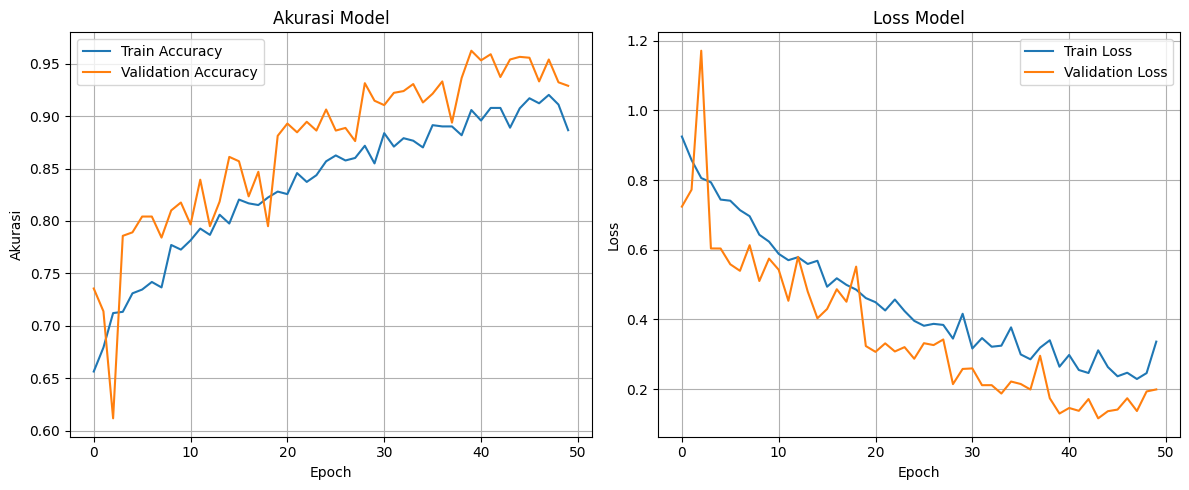

In [14]:
plt.figure(figsize=(12, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# **8. Simpan Ke SavedModel,TFJS, TFLite**

In [ ]:
def siapkan_saved_model():
    print("--- TAHAP 1: MEMUAT MODEL DAN MEMBUAT SAVEDMODEL & TFLITE ---")

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(6, activation='softmax') 
    ])
    print("[OK] Arsitektur model berhasil dibuat.")

    WEIGHTS_FILE = "best_model.weights.h5"
    if not os.path.exists(WEIGHTS_FILE):
        print(f"[ERROR] File bobot '{WEIGHTS_FILE}' tidak ditemukan!")
        return
    
    model.load_weights(WEIGHTS_FILE)
    print(f"[OK] Bobot dari '{WEIGHTS_FILE}' berhasil dimuat.")

    SAVED_MODEL_DIR = "saved_model"
    if os.path.exists(SAVED_MODEL_DIR):
        shutil.rmtree(SAVED_MODEL_DIR)
    
    model.export(SAVED_MODEL_DIR)
    print(f"[OK] Model berhasil diekspor ke folder '{SAVED_MODEL_DIR}'.")

    labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
    with open("labels.txt", "w") as f:
        f.write("\n".join(labels))
    print("[OK] File 'labels.txt' berhasil dibuat.")

    print("\n--> Mengonversi ke TFLite...")
    converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_DIR)
    tflite_model = converter.convert()
    os.makedirs("tflite_model", exist_ok=True)
    with open("tflite_model/model.tflite", "wb") as f:
        f.write(tflite_model)
    shutil.copy("labels.txt", "tflite_model/labels.txt")
    print("[SELESAI] Model TFLite dan labels.txt berhasil disimpan.")
    
    print("\n--- Proses persiapan model selesai. Folder 'saved_model' sudah siap untuk Tahap 2. ---")

if __name__ == "__main__":
    siapkan_saved_model()

print("untuk TFJS Di konversi Manual Melalui Terminal" "tensorflowjs_converter --input_format=tf_saved_model saved_model tfjs_model")

--- TAHAP 1: MEMUAT MODEL DAN MEMBUAT SAVEDMODEL & TFLITE ---
[OK] Arsitektur model berhasil dibuat.
[OK] Bobot dari 'best_model.weights.h5' berhasil dimuat.


c:\Users\fayiz_lgdvoec\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_10')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2323454305360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2323454303632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2323454305744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2323454306512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2323454306704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2323454307280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2323454307472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2323454308048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2323454308240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2323454308816: TensorSpec(shape=(), dtype=tf.resource, name=None)
[OK] Model berhasil diekspor ke folder